Code for calculating the CEvNS rates for LiF at a reactor.
- Part 1: Generate neutrino flux
- Part 2: Calculate nuclear recoil distributions as a function of neutrino energy
- Part 3: Calculate cross section, recoil distribution

Part 1. The flux is given in neutrinos/fission for each of the main fissile isotopes. We use parameters from CONUS+ paper (https://arxiv.org/abs/2501.05206v1), and fluxes from Silaeva & Sinev (https://arxiv.org/abs/2012.09917). We use the effective thermal energy release per 
fission from https://arxiv.org/abs/1212.6625.

TODO:
- Form factors
- Add pion decay-at-rest neutrinos
- Calculate atoms_per_kg, look-up table or target_Zs, target_As

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from utils import ioUtils, sourceUtils, targetUtils
from utils.constants import constants
import sys
import pandas as pd

################
##Parse Config##
################
configFileName = "config/LiF_reactor.jsonc"
config = ioUtils.parseConfig(configFileName)

#Load mass table. Indexed by symbol, and has:
# Z, A, nuc_mass_MeV, atom_mass_MeV
mass_dict = ioUtils.loadMassDict("data/mass_1.mas20.txt")
#Load spin density table. Indexed by symbol, and has:
# Sn, Sp
spinDensity_dict = ioUtils.loadSnSpDict("data/sn_sp.csv")

#Make targets. Indexed by symbol, and has:
# symbol,Z,A,N,nuc_mass_MeV,atom_mass_MeV,atom_frac,mass_frac,num_atoms,mass,sn,sp
targetObjects = targetUtils.makeTargets(config=config,mass_dict=mass_dict,spinDensity_dict=spinDensity_dict) 

#TODO: Make fluxes. Indexed by name (use 'total' for all). Each has:
# raw_energies, raw_flux, interpolated_energies, interpolated_flux, normalized_flux (nu /cm2/sec)
#For reactors: flux is given as neutrinos per fission per MeV
fluxObjects = sourceUtils.makeFluxObjects(config=config)

#TODO: Calculate CEvNS XS for each target

#TODO: Fold with neutrino spectrum

#TODO: Calculate recoil spectrum

#Plotting
colors=["tab:blue","tab:orange","tab:green","tab:red","tab:purple","black"]
plt.rcParams.update({'axes.titlesize': 14})
plt.rcParams.update({'axes.labelsize': 15})
plt.rcParams.update({'xtick.labelsize':13})
plt.rcParams.update({'ytick.labelsize':13}) 
plt.rcParams.update({'legend.fontsize':13}) 

Per 235U fission, raw values give 3.26 neutrinos/fission
Per 235U fission, interpolated values give 3.26 neutrinos/fission
Per 238U fission, raw values give 3.26 neutrinos/fission
Per 238U fission, interpolated values give 3.26 neutrinos/fission
Per 239Pu fission, raw values give 3.26 neutrinos/fission
Per 239Pu fission, interpolated values give 3.26 neutrinos/fission
Per 241Pu fission, raw values give 3.26 neutrinos/fission
Per 241Pu fission, interpolated values give 3.26 neutrinos/fission

1.0 GWth reactor produces 3.031e+19 fissions/sec
Total neutrino flux 20.0m from a 1.0 GWth reactor is 1.964e+16 nu/cm2/sec


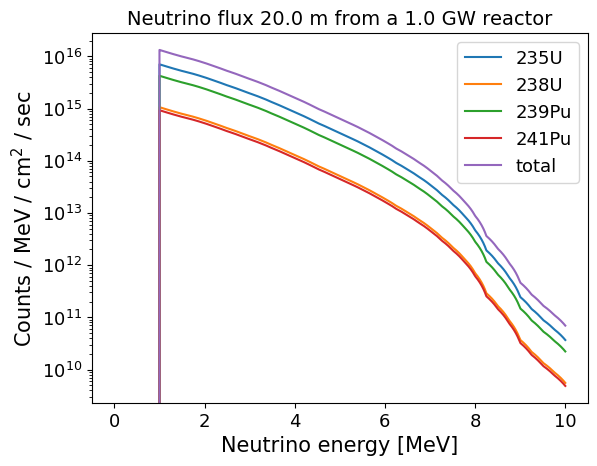

In [2]:
fig,ax = plt.subplots()

for name, fluxObject in fluxObjects.items():
  ax.plot(fluxObject.interpolated_energies,fluxObject.normalized_flux,label=name)

ax.set_yscale("log")
ax.legend()
ax.set_xlabel("Neutrino energy [MeV]")
ax.set_ylabel("Counts / MeV / cm$^2$ / sec")
ax.set_title(f"Neutrino flux {config['source']['params']['distance_m']} m from a {config['source']['params']['power_GWth']} GW reactor")
plt.show()

In [ ]:
###########################################################
##Calculate max recoil energy for highest energy neutrino##
########################################################### 
Enu_max_MeV = interpolated_energy_arr[-1]
T_max_MeV = 0
for i,target_isotope in enumerate(target_isotopes):
  test_Enu_max_MeV = 2*math.pow(Enu_max_MeV,2)/(mass_table[target_Zs[i]][target_As[i]]+2*Enu_max_MeV)
  if test_Enu_max_MeV > T_max_MeV:
    T_max_MeV = test_Enu_max_MeV

Ts_MeV = np.arange(Enr_step_size_MeV/2.,T_max_MeV+Enr_step_size_MeV/2.,Enr_step_size_MeV)

##################################
##CEvNS Cross Section Calculator##
##################################
#Based on https://arxiv.org/pdf/1803.09183, ignoring radiative corrections
prefix = math.pow(GF_MeV2,2)/(2.0*math.pi)
def calcCalcCrossSection(E_nu,M,Z,N,Sn,Sp):
  xs = np.zeros(Ts_MeV.size)

  G_V = (gp_V*Z + gn_V*N)*vector_form_factor
  G_A = (gp_A*2*Sp + gn_A*2*Sn) * axial_form_factor
  T_max = 2*math.pow(E_nu,2)/(M+2*E_nu)
  mask = (Ts_MeV <= T_max)

  Ts = Ts_MeV[mask]
  valid_xs = prefix * M * (np.power(G_V+G_A,2) + np.power(G_V-G_A,2) * np.power(1-Ts/E_nu,2) - (G_V**2 - G_A**2)*M*Ts / (E_nu**2))
  valid_xs = valid_xs * hbarc_MeVcm * hbarc_MeVcm #convert to cm2

  xs[:len(valid_xs)] = valid_xs

  xs_total = np.trapz(xs, Ts_MeV)

  xs = xs * Enr_step_size_MeV

  return np.asarray(xs),xs_total

############################################
##Loop through isotopes, neutrino energies##
############################################
cross_sections = []
differential_cross_sections = []
vector_cross_sections = []
for i,isotope in enumerate(target_isotopes):
  cross_sections.append([])
  vector_cross_sections.append([])
  differential_cross_sections.append([])
  Z = target_Zs[i]
  A = target_As[i]
  N = A - Z
  M = mass_table[Z][A]
  Sn = Sn_table[Z][A]
  Sp = Sp_table[Z][A]

  for E_nu in interpolated_energy_arr:
    differential_cross_section,total_cross_section = calcCalcCrossSection(E_nu,M,Z,N,Sn,Sp)
    cross_sections[i].append(total_cross_section)
    differential_cross_sections[i].append(differential_cross_section)

  Sn = 0
  Sp = 0
  for E_nu in interpolated_energy_arr:
    dummy,total_cross_section = calcCalcCrossSection(E_nu,M,Z,N,Sn,Sp)
    vector_cross_sections[i].append(total_cross_section)


In [ ]:
########
##Plot##
########
for i,isotope in enumerate(target_isotopes):
  plt.plot(interpolated_energy_arr,cross_sections[i],color=colors[i],label=target_isotopes[i]+" CEvNS")
  #plt.plot(interpolated_energy_arr,vector_cross_sections[i],"--",color=colors[i],label=target_isotopes[i]+" (vector only)")
  #print(np.sum(np.array(cross_sections[i])*total_interpolated_flux*np.array(target_nAtoms[i])*86400*exposure_days))

  '''
  print(cross_sections[i])
  print(vector_cross_sections[i])
  diff = np.array([abs(cross_sections[i][j] - vector_cross_sections[i][j])/cross_sections[i][j] if cross_sections[i][j] > 0 else 0 for j in range(0,len(cross_sections[i]))])
  plt.plot(interpolated_energy_arr,diff)
  '''

'''
#Just for fun, inelastic NC xs from HC Lee
def calcInelastic(arr,threshold_MeV,ga_sigmatau3_squared):
  inelastic_xs = []
  for nrg in arr:
    if nrg <= threshold_MeV:
      inelastic_xs.append(0.)
    else:
      inelastic_xs.append(4.2e-45*math.pow(nrg-threshold_MeV,2)*ga_sigmatau3_squared)
  return inelastic_xs

inelastic_thresholds = [0.478,1.554]
inelastic_matrixelements = [1.78,0.05]
inelastic_names = ["$^7$Li (0.478 MeV)","$^{19}$F (1.554 MeV)"]
for i,thresh in enumerate(inelastic_thresholds):
  inelastic_xs = calcInelastic(interpolated_energy_arr,thresh,inelastic_matrixelements[i])
  plt.plot(interpolated_energy_arr,inelastic_xs,color=colors[i+4],label=inelastic_names[i],ls="dashed")
'''


#Optional - load IBD xs
#https://arxiv.org/pdf/2311.16730
ibdFilename = "xs_arxiv2311.16730.csv"
ibd_energies = []
ibd_xs = []
with open(ibdFilename,"r") as ibdFile:
  for iline,line in enumerate(ibdFile):
    if iline>0:
      line = line.strip("\n")
      if not line=="":
        lineParts = line.split(",")
        ibd_energies.append(float(lineParts[0]))
        ibd_xs.append(float(lineParts[1])*math.pow(10,-41))
plt.plot(ibd_energies,ibd_xs,label = "$^{1}$H IBD",color="black",ls="dashed")


plt.legend(loc="right")
#plt.yscale("log")
plt.xlabel("Neutrino energy [MeV]")
plt.ylabel("Cross section [cm$^2$]")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlim(left=0,right=10)
plt.yscale("log")
#plt.ylim(0.0015,0.0025)
plt.savefig("LiF_xs_withIBD_LE.png",dpi=300,bbox_inches="tight")


plt.show()


In [ ]:
#################################
##Calculate recoil distribution##
#################################
differential_recoil_distributions = [np.zeros(Ts_MeV.size) for isotope in target_isotopes]

for itarget,isotope in enumerate(target_isotopes):
  #1. Step through neutrino energies, calculate flux in that bin (value * bin width)
  for inrg,E_nu in enumerate(interpolated_energy_arr):
    fluence = total_interpolated_flux[inrg] * 86400 * exposure_days

    #2. Step through recoil distributions, scale by flux and targets, add to global recoil list
    differential_counts = differential_cross_sections[itarget][inrg] * fluence * target_nAtoms[itarget]
    differential_recoil_distributions[itarget] = differential_recoil_distributions[itarget] + differential_counts


  differential_recoil_distributions[itarget] = differential_recoil_distributions[itarget]


In [ ]:
########
##PLOT##
########
scaleFactor = 0.001/Enr_step_size_MeV
Ts_keV = Ts_MeV*1000
fig,ax = plt.subplots()
for itarget,isotope in enumerate(target_isotopes):
  ax.plot(Ts_keV,differential_recoil_distributions[itarget]*scaleFactor, label=target_isotopes[itarget])
  integrated_counts = np.trapz(differential_recoil_distributions[itarget]/Enr_step_size_MeV,Ts_MeV)
  print(f"For {target_isotopes[itarget]}, expect {integrated_counts:.1f} counts")

total_recoil_dist = np.sum(differential_recoil_distributions, axis=0)*scaleFactor
ax.plot(Ts_keV,total_recoil_dist,"--",label="Total",color="k")
plt.legend()
plt.yscale("log")
plt.xlabel("Nuclear recoil energy [keV]")
plt.ylabel(f"Counts/keV/{target_mass_kg}kg {output_name}/{exposure_days} days")
plt.title(f"{target_mass_kg}kg of {output_name} located {distance_to_core_m}m from a {power_GW}GW reactor")
ax.set_xlim(left=0,right=20)
ax.set_ylim(bottom=0.1)
plt.savefig("LiF_recoilDist.png",dpi=300,bbox_inches="tight")
plt.show()